In [1]:
from pathlib import Path
import os
os.chdir("..")

In [2]:
import lovely_tensors as lt
lt.monkey_patch()

In [3]:

import pickle
from einops import rearrange
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from PIL import Image
from torchmetrics import F1Score, MetricCollection
from torchvision.transforms.functional import resize
import torch.optim.lr_scheduler as lr_scheduler


import numpy as np
import torch

from ffss.utils.utils import ResultDict, StrEnum, torch_dict_load, torch_dict_save, to_device
from ffss.models import build_model
from ffss.data import get_preprocessing, get_testloaders
from ffss.data.utils import (
    AnnFileKeys,
    PromptType,
    BatchKeys,
)
from ffss.substitution import Substitutor
from ffss.demo.visualize import (
    crop_seg,
    draw_all,
    draw_masks,
    feature_map_pca_heatmap,
    get_image,
    plot_seg,
)

In [4]:
parameters = {
    'dataloader': {'num_workers': 0}, 
    'dataset': {
        'preprocess': {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'image_size': 384},
        'datasets': {
            'test_weedmap': {
                'train_root': '../Datasets/WeedMap/0_rotations_processed_003_test/RedEdge/000',
                'test_root': '../Datasets/WeedMap/0_rotations_processed_003_test/RedEdge/003',
                'prompt_images': [
                    # 'frame0009_2.png',
                    'frame0021_2.png',
                    'frame0033_3.png',
                    'frame0034_1.png',
                    'frame0048_0.png',
                    ],
                'remove_black_images': False}
            },
    },
    'model': {
        'name': 'dcama',
        'backbone': 'swin',
        'backbone_checkpoint': 'checkpoints/swin_base_patch4_window12_384.pth',
        'model_checkpoint': 'checkpoints/swin_fold0_pascal_modcross_soft.pt',
        # 'model_checkpoint': "checkpoints/swin_fold0.pt",
        'concat_support': False,
        'image_size': 384,
        'train_backbone': True
        }, 
    'refinement': {'lr': 0.01, 'max_iterations': 1000}
}

In [5]:
def exg_refine(image, threshold, prediction):
    img = resize(image, prediction.shape[-2:])
    exg = 2*img[:, 1] - img[:, 0] + img[:, 2]
    exg_mask = ((exg - exg.min())/(exg.max() - exg.min()) > threshold)
    return (exg_mask*prediction) 

In [6]:
preprocess = get_preprocessing(parameters["dataset"])

### Get WeedMap

In [7]:
test_loaders = get_testloaders(
        parameters["dataset"],
        parameters["dataloader"]
    )
weedmap = test_loaders["test_weedmap"]

In [8]:
class FocalLoss(nn.Module):
    def __init__(
        self, gamma: float = 2.0, weights=None
    ):
        super().__init__()
        self.gamma = gamma
        self.weights = weights

        self.reduction = torch.mean

    def __call__(self, x, target):
        ce_loss = F.cross_entropy(x, target, reduction="none")
        pt = torch.exp(-ce_loss)
        
        if self.weights is not None:
            weights = self.weights.to(x.device)[target]
            focal_loss = torch.pow((1 - pt), self.gamma) * weights * ce_loss
        else:
            focal_loss = torch.pow((1 - pt), self.gamma) * ce_loss

        return self.reduction(focal_loss)

### Get Model

In [9]:
from ffss.models.dcama.dcama import DCAMA, DCAMA_model
from einops import repeat, reduce
from operator import add
from ffss.models.dcama.swin_transformer import SwinTransformer


class WeeDCAMA:
    def __init__(self, backbone, pretrained_path, use_original_imgsize, image_size, concat_support=True, train_backbone=False):
        self.backbone = backbone
        self.use_original_imgsize = use_original_imgsize
        self.train_backbone = train_backbone


        self.feature_extractor = SwinTransformer(img_size=384, patch_size=4, window_size=12, embed_dim=128,
                                        depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32])
        self.feature_extractor.load_state_dict(torch.load(pretrained_path)['model'])
        self.feat_channels = [128, 256, 512, 1024]
        self.nlayers = [2, 2, 18, 2]
        self.feature_extractor.eval()

        # define model
        self.lids = reduce(add, [[i + 1] * x for i, x in enumerate(self.nlayers)])
        self.stack_ids = torch.tensor(self.lids).bincount()[-4:].cumsum(dim=0)
        self.crop_model = DCAMA_model(in_channels=self.feat_channels, stack_ids=self.stack_ids, concat_support=concat_support)
        self.weed_model = DCAMA_model(in_channels=self.feat_channels, stack_ids=self.stack_ids, concat_support=concat_support)
        self.classifier = nn.Conv2d(32, 3, kernel_size=1)
        
    def forward_1shot(self, query_img, support_img, support_mask):
        if self.train_backbone:
            query_feats = self.extract_feats(query_img)
            support_feats = self.extract_feats(support_img)
        else:
            with torch.no_grad():
                query_feats = self.extract_feats(query_img)
                support_feats = self.extract_feats(support_img)

        return self.model(query_feats, support_feats, support_mask.clone())

    def extract_feats(self, img):
        r""" Extract input image features """
        feats = []

        _ = self.feature_extractor.forward_features(img)
        for feat in self.feature_extractor.feat_maps:
            bsz, hw, c = feat.size()
            h = int(hw ** 0.5)
            feat = feat.view(bsz, h, h, c).permute(0, 3, 1, 2).contiguous()
            feats.append(feat)

        return feats

    def predict_mask_nshot(self, batch, nshot):
        r""" n-shot inference """
        query_img = batch[BatchKeys.IMAGES][:, 0]
        support_imgs = batch[BatchKeys.IMAGES][:, 1:]
        support_masks = batch[BatchKeys.PROMPT_MASKS]

        if nshot == 1:
            result = self.forward_1shot(query_img, support_imgs[:, 0], support_masks[:, 0])
        else:
            query_feats = self.extract_feats(query_img)
            n_support_feats = []
            for k in range(nshot):
                support_feats = self.extract_feats(support_imgs[:, k])
                n_support_feats.append(support_feats)
            result = self.model(query_feats, n_support_feats, support_masks.clone(), nshot)
        logit_mask = result[ResultDict.LOGITS]

        if self.use_original_imgsize:
            org_qry_imsize = tuple([batch[BatchKeys.DIMS][1].item(), batch[BatchKeys.DIMS][0].item()])
            logit_mask = F.interpolate(logit_mask, org_qry_imsize, mode='bilinear', align_corners=True)
        else:
            logit_mask = F.interpolate(logit_mask, support_imgs[0].size()[2:], mode='bilinear', align_corners=True)

        result[ResultDict.LOGITS] = logit_mask
        return result

    def _preprocess_masks(self, masks, dims):
        B, N, C, H, W = masks.size()
        # remove bg from masks
        masks = masks[:, :, 1:, ::]
        return masks

    def forward(self, x):

        masks = self._preprocess_masks(
            x[BatchKeys.PROMPT_MASKS], x[BatchKeys.DIMS]
        )
        assert (
            masks.shape[0] == 1
        ), "Only tested with batch size = 1"
        
        c = 0 # crop
        class_examples = x[BatchKeys.FLAG_EXAMPLES][:, :, c + 1]
        n_shots = class_examples.sum().item()
        crop_input_dict = {
            BatchKeys.IMAGES: x[BatchKeys.IMAGES],
            BatchKeys.PROMPT_MASKS: masks[:, :, c, ::][
                class_examples
            ].unsqueeze(0),
        }
        crop_result = self.predict_mask_nshot(crop_input_dict, n_shots)
        c = 1 # weed
        class_examples = x[BatchKeys.FLAG_EXAMPLES][:, :, c + 1]
        n_shots = class_examples.sum().item()
        weed_input_dict = {
            BatchKeys.IMAGES: x[BatchKeys.IMAGES],
            BatchKeys.PROMPT_MASKS: masks[:, :, c, ::][
                class_examples
            ].unsqueeze(0),
        }
        weed_result = self.predict_mask_nshot(weed_input_dict, n_shots)
        fmap = torch.cat([crop_result[ResultDict.MIX_2], weed_result[ResultDict.MIX_2]], dim=1)
        
        logits = self.classifier(fmap)
        logits = self.postprocess_masks(logits, x["dims"])

        return {
            ResultDict.LOGITS: logits,
        }

    def postprocess_masks(self, logits, dims):
        max_dims = torch.max(dims.view(-1, 2), 0).values.tolist()
        dims = dims[:, 0, :]  # get real sizes of the query images
        logits = [
            F.interpolate(
                torch.unsqueeze(logit, 0),
                size=dim.tolist(),
                mode="bilinear",
                align_corners=False,
            )
            for logit, dim in zip(logits, dims)
        ]

        logits = torch.cat(
            [
                F.pad(
                    mask,
                    (
                        0,
                        max_dims[1] - dims[i, 1],
                        0,
                        max_dims[0] - dims[i, 0],
                    ),
                    mode="constant",
                    value=float("-inf"),
                )
                for i, mask in enumerate(logits)
            ]
        )
        return logits

    def get_learnable_params(self, train_params):
        return self.parameters()

In [10]:
device = "cuda"
def build_weedcama(
    backbone: str = "swin",
    backbone_checkpoint: str = "checkpoints/backbone.pth",
    model_checkpoint: str = "checkpoints/dcama.pth",
    image_size: int = 384,
    concat_support: bool = True,
    custom_preprocess: bool = False,
    train_backbone: bool = False,
    **kwargs,
):
    model = WeeDCAMA(
        backbone, backbone_checkpoint, use_original_imgsize=False, image_size=image_size, concat_support=concat_support, train_backbone=train_backbone
    )
    params = model.state_dict()
    state_dict = torch.load(model_checkpoint)

    for k1, k2 in zip(list(state_dict.keys()), params.keys()):
        state_dict[k2] = state_dict.pop(k1)

    model.load_state_dict(state_dict, strict=False)
    model.to(device)
    model.eval()
    return model

model = build_weedcama(**parameters["model"])

### Get the training data

In [11]:
examples = weedmap.dataset.extract_prompts()
examples = to_device(examples, device)

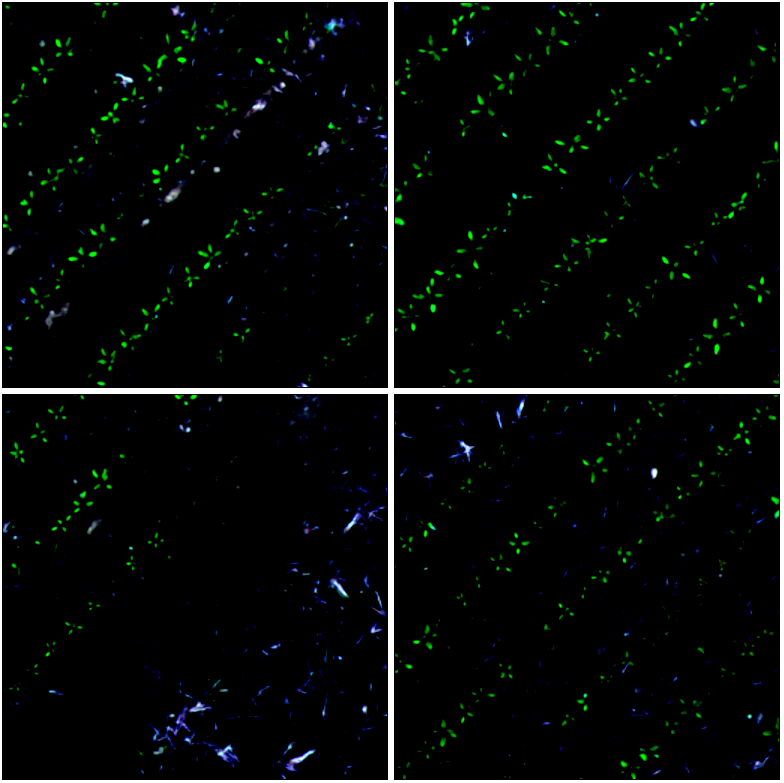

In [12]:
examples[BatchKeys.IMAGES].rgb

In [13]:
metrics = MetricCollection(
    metrics=[
            F1Score(
                task="multiclass",
                num_classes=weedmap.dataset.num_classes,
                average="macro",
            )
    ]
).to(device)

In [14]:
lr = 1.e-3
max_iterations = 5000
sched_patience = 10
sched_factor = 0.5
min_lr = 1.e-6

hot_parameters = [
    # "model.conv1",
    # "model.conv2",
    # "model.conv3",
    # "model.mixer1",
    # "model.mixer2",
    # "model.mixer3",
]
train_backbone = False

if hot_parameters:
    for name, param in model.named_parameters():
        if any([
            hot_parameter in name
            for hot_parameter in hot_parameters
        ]):
            param.requires_grad = True
        else:
            param.requires_grad = False
for name, param in model.feature_extractor.named_parameters():
    if train_backbone:
        param.requires_grad = True
    else:
        param.requires_grad = False
        
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Training {name}")
        
support_gt = examples[BatchKeys.PROMPT_MASKS].argmax(dim=1).unsqueeze(0)

support_batch = {
    BatchKeys.IMAGES: examples[BatchKeys.IMAGES].unsqueeze(0),
    BatchKeys.PROMPT_MASKS: examples[BatchKeys.PROMPT_MASKS].unsqueeze(0),
    BatchKeys.FLAG_MASKS: examples[BatchKeys.FLAG_MASKS].unsqueeze(0),
    BatchKeys.FLAG_EXAMPLES: examples[BatchKeys.FLAG_EXAMPLES].unsqueeze(0),
    BatchKeys.DIMS: examples[BatchKeys.DIMS].unsqueeze(0)
}

_, class_counts = support_gt.unique(return_counts=True)
loss_weights = class_counts.sum() / (2*class_counts)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=sched_patience, factor=sched_factor, min_lr=min_lr)
# loss_fn = nn.CrossEntropyLoss(weight=loss_weights)
loss_fn = FocalLoss()

Training model.DCAMA_blocks.0.linears.0.weight
Training model.DCAMA_blocks.0.linears.0.bias
Training model.DCAMA_blocks.0.linears.1.weight
Training model.DCAMA_blocks.0.linears.1.bias
Training model.DCAMA_blocks.1.linears.0.weight
Training model.DCAMA_blocks.1.linears.0.bias
Training model.DCAMA_blocks.1.linears.1.weight
Training model.DCAMA_blocks.1.linears.1.bias
Training model.DCAMA_blocks.2.linears.0.weight
Training model.DCAMA_blocks.2.linears.0.bias
Training model.DCAMA_blocks.2.linears.1.weight
Training model.DCAMA_blocks.2.linears.1.bias
Training model.conv1.0.weight
Training model.conv1.0.bias
Training model.conv1.1.weight
Training model.conv1.1.bias
Training model.conv1.3.weight
Training model.conv1.3.bias
Training model.conv1.4.weight
Training model.conv1.4.bias
Training model.conv1.6.weight
Training model.conv1.6.bias
Training model.conv1.7.weight
Training model.conv1.7.bias
Training model.conv2.0.weight
Training model.conv2.0.bias
Training model.conv2.1.weight
Training mod

In [15]:
substitutor = Substitutor(substitute=True, subsample=1)
support_set_len = support_batch[BatchKeys.IMAGES].shape[1]
metric_update = 5
metrics.reset()

for i in range(max_iterations):
    loss_total = 0
    substitutor.reset(batch=(support_batch, support_gt))
    metrics.reset()
    for batch, gt in substitutor:
        result = model(batch)
        logits = result[ResultDict.LOGITS]
        loss_value = loss_fn(logits, gt) / support_set_len
        loss_value.backward()
        loss_total += loss_value.item()
        metrics.update(logits.argmax(dim=1), gt)
    if i % metric_update == 0:
        metric_values = metrics.compute()
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Iteration {i} {loss_value.item()}, Metrics {metric_values}, LR {current_lr}")
    else:
        print(f"Iteration {i} {loss_value.item()}")
    optimizer.step()
    optimizer.zero_grad()

Iteration 0 0.11954442411661148, Metrics {'MulticlassF1Score': tensor cuda:0 0.014}, LR 0.001
Iteration 1 0.06106799468398094
Iteration 2 0.08582843840122223
Iteration 3 0.05825845152139664
Iteration 4 0.04378414899110794
Iteration 5 0.04850754886865616, Metrics {'MulticlassF1Score': tensor cuda:0 0.315}, LR 0.001
Iteration 6 0.040553268045186996
Iteration 7 0.040831662714481354
Iteration 8 0.03658051788806915
Iteration 9 0.03705363720655441
Iteration 10 0.030380405485630035, Metrics {'MulticlassF1Score': tensor cuda:0 0.315}, LR 0.001
Iteration 11 0.034396424889564514
Iteration 12 0.02793387696146965
Iteration 13 0.031276389956474304
Iteration 14 0.025898775085806847
Iteration 15 0.030305195599794388, Metrics {'MulticlassF1Score': tensor cuda:0 0.315}, LR 0.001
Iteration 16 0.02486472949385643
Iteration 17 0.029011938720941544
Iteration 18 0.024255791679024696
Iteration 19 0.02855510823428631
Iteration 20 0.023086149245500565, Metrics {'MulticlassF1Score': tensor cuda:0 0.315}, LR 0.0

KeyboardInterrupt: 

In [16]:
substitutor = Substitutor(substitute=True)
support_set_len = support_batch[BatchKeys.IMAGES].shape[1]
metrics.reset()

loss_total = 0
substitutor.reset(batch=(support_batch, support_gt))
for batch, gt in substitutor:
    with torch.no_grad():
        result = model(batch)
    logits = result[ResultDict.LOGITS]
    metrics.update(logits.argmax(dim=1), gt)
metric_values = metrics.compute()
print("Train metrics: ", metric_values)

Train metrics:  {'MulticlassF1Score': tensor cuda:0 0.665}


In [17]:
substitutor.reset(batch=(support_batch, support_gt))

In [18]:
batch, gt = next(substitutor)

In [19]:
with torch.no_grad():
    result = model(batch)
    logits = result[ResultDict.LOGITS]

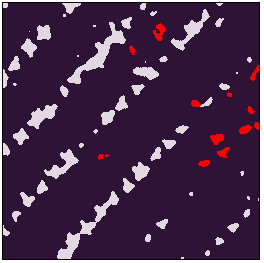

In [20]:
gt.chans

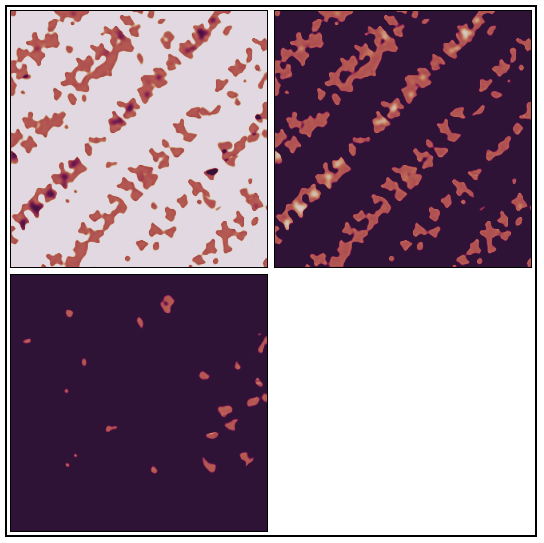

In [21]:
F.softmax(logits, dim=1).chans

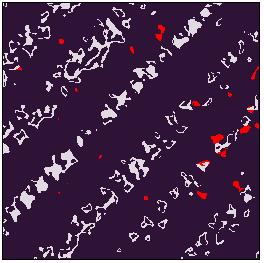

In [22]:
prediction = logits.argmax(dim=1)
prediction.chans

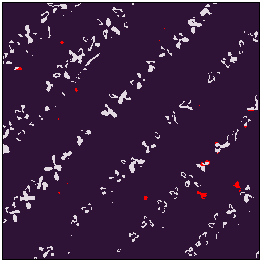

In [ ]:
exg_refine(batch[BatchKeys.IMAGES][:, 0], 0.20, prediction).chans

### Test everything

In [24]:
from copy import deepcopy

def merge_dicts(prompts, imgs):
    device = imgs[BatchKeys.IMAGES].device
    merge_prompts = deepcopy(prompts)
    out = {}
    for k in set(list(imgs.keys()) + list(merge_prompts.keys())):
        if k in imgs and prompts:
            dim = 0
            if k == BatchKeys.IMAGES:
                merge_prompts[k] = merge_prompts[k].unsqueeze(dim=0)
                dim = 1
            out[k] = torch.cat([imgs[k].cpu(), merge_prompts[k].cpu()], dim=dim).to(
                device
            )
            if k == BatchKeys.DIMS:
                out[k] = out[k].unsqueeze(dim=0).to(device)
        elif k in imgs:
            out[k] = imgs[k].to(device)
        else:
            out[k] = merge_prompts[k].unsqueeze(dim=0).to(device)
    return out

In [ ]:
from tqdm import tqdm

metrics.reset()
refined_metrics = metrics.clone()
bar = tqdm(
    enumerate(weedmap),
    total=len(weedmap),
    postfix={"loss": 0},
    desc="Test: ",
)
update_frequency = 10
with torch.no_grad():
    for batch_idx, batch_dict in bar:
        image_dict, gt = batch_dict
        input_dict = to_device(merge_dicts(prompts=examples, imgs=image_dict), device)
        gt = to_device(gt, device)
        outputs = model(input_dict)[ResultDict.LOGITS]
        outputs = torch.argmax(outputs, dim=1)
        dims = image_dict[BatchKeys.DIMS][0].tolist()
        outputs = outputs[:, : dims[0], : dims[1]]
        refined_outputs = exg_refine(input_dict[BatchKeys.IMAGES][:, 0], 0.20, outputs)
        metrics.update(outputs, gt)
        refined_metrics.update(refined_outputs, gt)
        if batch_idx % update_frequency == 0:
            metrics_values = metrics.compute()
            bar.set_postfix({k: v.item() for k, v in metrics_values.items()})
    metrics_values = metrics.compute()
    refined_metrics_values = refined_metrics.compute()

    for k, v in metrics_values.items():
        print(f"Test - {k}: {v}")
    for k, v in refined_metrics_values.items():
        print(f"Refined Test - {k}: {v}")

Test:   0%|          | 0/408 [00:00<?, ?it/s, loss=0]

Test: 100%|██████████| 408/408 [01:34<00:00,  4.30it/s, MulticlassF1Score=0.429]

Test - MulticlassF1Score: 0.42863836884498596
Refined Test - MulticlassF1Score: 0.43976134061813354


In [29]:
iterator = iter(weedmap)

In [46]:
batch_dict  = next(iterator)

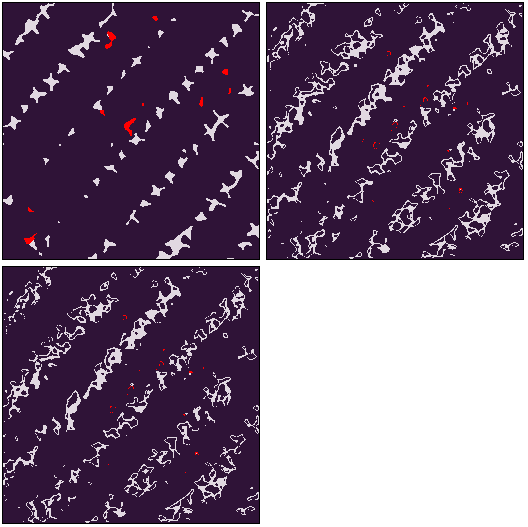

In [47]:
image_dict, gt = batch_dict
input_dict = to_device(merge_dicts(prompts=examples, imgs=image_dict), device)
gt = to_device(gt, device)
outputs = model(input_dict)[ResultDict.LOGITS]
outputs = torch.argmax(outputs, dim=1)

refined = exg_refine(input_dict[BatchKeys.IMAGES][:, 0], 0.20, outputs)

torch.cat([gt, outputs, refined], dim=0).chans